# TensorFlow 编程基础

## 运行原理

运行原理包括：**定义**----**运行**

- 定义  
tensor：张量，多维数组  
Variable：变量，对模型中的参数进行定义  
placeholder：占位符，定义tensor参数类型  
operation(OP)：节点操作

图：计算任务，session启动图，feed，传入数据；fetch，取出数据得到结果

### code实例

In [1]:
import tensorflow as tf

E:\anaconda\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


- the Session or sess  
sess.run(fetches, feed_dict=None, options=None, run_metadata=None)

In [3]:
hello = tf.constant('hello, the world')
sess = tf.Session()
print(sess.run(hello))
sess.close()

b'hello, the world'


In [4]:
a = tf.constant(3)
b = tf.constant(4)
with tf.Session() as sess:
    res = sess.run(a+b)
print(res)

7


- feed

In [10]:
x = tf.placeholder(tf.int16)
y = tf.placeholder(tf.int16)

with tf.Session() as sess:
    res = sess.run(x+y, feed_dict={x:3, y:4})
    print(res)

7


- 指定GPU  
①with tf.device('/gpu:0')  
②config = tf.ConfigProto(log_device_placement=True, allow_soft_placement=True)

In [16]:
with tf.Session() as sess:
    with tf.device("/cpu:0"):  # "/gpu:0"
        res = sess.run(x*y, feed_dict={x:2, y:3})
        print(res)


6


- 重置清空placeholder

In [13]:
tf.reset_default_graph()

- 保存和载入模型

In [5]:
#saver = tf.train.Saver()

# 训练完成后
# saver.save(sess, "save_path/file_name")

# 载入模型
# saver.restore(sess, "save_path/file_name")

### 添加 Checkpoint

In [45]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [59]:
plotdata = {'batchsize':[], 'loss':[]}

def moving_average(a, w=10):
    if len(a) < w:
        return a[:]
    return [val if idx < w else sum(a[(idx-w):idx]) / w for idx,val in enumerate(a)]

In [47]:
train_X = np.linspace(-1,1,100)
train_Y = 2 * train_X + np.random.randn(*train_X.shape) * 0.3

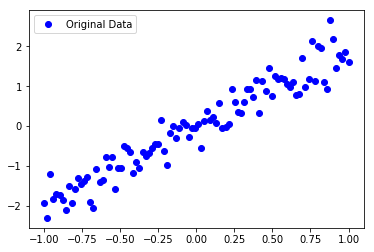

In [48]:
plt.plot(train_X, train_Y, 'bo', label='Original Data')
plt.legend()
plt.show()

In [49]:
tf.reset_default_graph()

In [50]:
X = tf.placeholder('float')
Y = tf.placeholder('float')

In [51]:
W = tf.Variable(tf.random_normal([1]), name='weight')
b = tf.Variable(tf.zeros([1]), name='bias')

In [52]:
z = tf.multiply(X, W) + b

- 显示模型函数

In [53]:
def plot_grah():
    plt.plot(train_X, train_Y, 'ro', label='Original Data')
    plt.plot(train_X, sess.run(W) * train_X + sess.run(b), label='Fitted W Line')
    plt.legend()
    plt.show()
    
    plotdata['avgloss'] = moving_average(plotdata['loss'])
    plt.figure(1)
    plt.subplot(211)
    plt.plot(plotdata['batchsize'], plotdata['avgloss'], 'b--')
    plt.xlabel('minibatch number')
    plt.ylabel('loss')
    plt.title('minibatch vs training loss')
    plt.show()

In [54]:
cost = tf.reduce_mean(tf.square(Y-z))
learning_rate = 0.01
optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(cost)

- 模型设置和训练

In [55]:
init = tf.global_variables_initializer()
training_epochs = 20
display_step = 2
saver = tf.train.Saver(max_to_keep=1)
savedir = './log/'

Epoch: 0 cost= 0.42553994 w= [1.0790081] b= [0.23924102]
Epoch: 2 cost= 0.13279781 w= [1.7031491] b= [0.07064321]
Epoch: 4 cost= 0.10778012 w= [1.8722472] b= [0.00694597]
Epoch: 6 cost= 0.10579005 w= [1.9161005] b= [-0.0098624]
Epoch: 8 cost= 0.1055802 w= [1.9274417] b= [-0.01421426]
Epoch: 10 cost= 0.10554635 w= [1.9303739] b= [-0.01533941]
Epoch: 12 cost= 0.10553897 w= [1.9311322] b= [-0.01563042]
Epoch: 14 cost= 0.10553713 w= [1.9313285] b= [-0.01570578]
Epoch: 16 cost= 0.10553667 w= [1.9313794] b= [-0.01572527]
Epoch: 18 cost= 0.10553656 w= [1.9313924] b= [-0.01573028]
finished
cost= 0.105536535 W= [1.9313947] b= [-0.01573112]


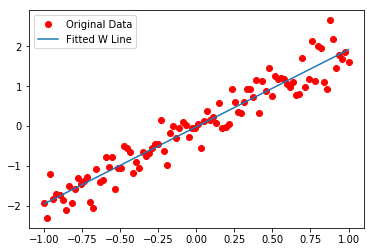

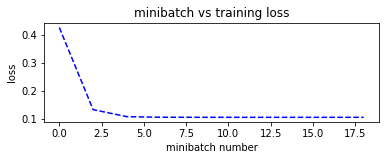

In [60]:
with tf.Session() as sess:
    # 先run init
    sess.run(init)
    
    # 导入参数
    for epoch in range(training_epochs):
        for x,y in zip(train_X, train_Y):
            sess.run(optimizer, feed_dict={X:x, Y:y})
            
        # 输出训练信息
        if epoch % display_step == 0:
            loss = sess.run(cost, feed_dict={X:train_X, Y:train_Y})
            print('Epoch:',epoch,'cost=',loss,'w=',sess.run(W),'b=',sess.run(b))
            if loss != 'NA':
                plotdata['batchsize'].append(epoch)
                plotdata['loss'].append(loss)
            saver.save(sess, savedir+'linermodel.cpkt', global_step=epoch)
    print('finished')
    print('cost=',sess.run(cost, feed_dict={X:train_X, Y:train_Y}),'W=',sess.run(W),'b=',sess.run(b))
    
    # 显示模型
    plot_grah()

- 重启session，载入检查点

In [61]:
load_epoch = 18
with tf.Session() as sess2:
    sess2.run(tf.global_variables_initializer())
    saver.restore(sess2, savedir+'linermodel.cpkt-' + str(load_epoch))
    print('x=0.2,z=',sess2.run(z,feed_dict={X:0.2}))

INFO:tensorflow:Restoring parameters from ./log/linermodel.cpkt-18
x=0.2,z= [0.3705482]
